# Projekt IAU  
## 2. časť - Predspracovanie údajov 
### Vypracovali: Marek Adamovič, Michal Pidanič
### Číslo datasetu: 32
### Podiel práce: 50/50

In [175]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# 1. Integrácia a čistenie dát
## Načítanie a výpis ukážky datasetu - labor.csv:

In [176]:
df_labor = pd.read_csv("data/labor.csv", sep='\t')
df_labor.tail()


,Unnamed: 0,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,ssn,leukocyty,ast,hematokrit,er-cv,hemoglobin,name,alt
9917,9917,1.0,7.92703,no,91.00875,7.32437,7.89392,5.58123,3.90769,single,222-02-8839,7.86491,32.48746,5.55737,68.86183,9.06266,Kathryn Joseph,1.23304
9918,9918,1.0,4.79625,no,2.41949,5.07378,71.42731,5.63469,4.55839,separated,178-80-3826,5.87616,66.92216,6.52756,44.38480,7.20484,Matthew Hampton,0.54876
9919,9919,1.0,7.75338,Y,52.16544,7.05607,70.20597,7.76704,5.08319,separated,117-91-4520,8.55812,57.18525,8.04531,36.38706,5.20149,James Nicholson,1.04357
9920,9920,0.0,7.75073,Y,15.83292,7.33310,78.44987,7.51062,8.47775,divoced,876-69-2400,7.29457,48.81077,7.64010,62.68887,5.52321,Michael Brown,1.18430
9921,9921,0.0,7.85219,no,65.28356,7.27391,35.52075,4.58541,5.34337,single,190-02-7522,6.48293,57.15174,7.03839,66.12604,4.31294,Carol Howard,1.35656


## Načítanie a výpis ukážky datasetu - profiles.csv:

In [177]:
df_profiles = pd.read_csv("data/profiles.csv", sep='\t')
df_profiles.tail()

,Unnamed: 0,race,job,blood_group,birthdate,sex,name,company,ssn,residence
3171,3171,White,Publishing copy,O+,2017-12-23,M,Gabriel Morgan,"Barnett, Gomez and Johnson",801-84-3689,USNS Mcdaniel\r\nFPO AP 59479
3172,3172,Black,IT trainer,O-,"02/26/1966, 00:00:00",F,Kimberly Velasquez,"Smith, Pennington and Wheeler",031-90-5782,890 Stephens Trail Suite 878\r\nNew Laurentown...
3173,3173,White,Retail buyer,AB+,"04/01/1943, 00:00:00",M,Luis Campbell,Hinton LLC,835-53-0272,"2386 Claudia Place\r\nRobertsmouth, UT 68376"
3174,3174,White,"Surveyor, commercial/residential",B-,12 Mar 1959,M,Gilbert Hunt,"Smith, Hall and Hall",341-34-6796,"39934 Montes Estate\r\nDarrylfort, SC 18244"
3175,3175,Asian,"Social research officer, government",B+,1961-05-26,M,Richard Franklin,Smith-Cortez,029-79-0829,34480 Jackson Mountains Suite 817\r\nTaylorlan...


Keďže máme ľudí s rovnakým menom, nevieme jednoznačne priradiť hodnoty z druhého datasetu k prvému. Z toho dôvodu sa zbavíme všetkyćh mien, ktoré mali v datasete duplikát.

In [178]:
print(sum(df_profiles.name.duplicated()))
df_profiles = df_profiles.drop_duplicates(subset=["name"], keep=False)
print(sum(df_profiles.name.duplicated()))

67
0


Vytvoríme si nový stĺpec, do ktorého priradíme vek v rokoch, ktorý zistíme vďaka dátumu narodenia. Následne skontrolujeme pomocou describe, či je vek v prijateľnom intervale (teda že nemáme mínusové hodnoty alebo 200 ročných ľudí)

In [179]:
df_profiles["age"] = (pd.to_datetime(dt.date.today()) - pd.to_datetime(df_profiles.birthdate)).dt.days / 365
#sum(df_profiles["age"].isnull())
df_profiles.age.describe()

count    3048.000000
mean       57.732141
std        33.652901
min         0.172603
25%        28.597945
50%        58.042466
75%        87.003425
max       116.216438
Name: age, dtype: float64

## Zlúčenie datasetov
Z druhého datasetu zoberiem hodnoty, ktoré sa budú hodiť a podopĺňam ich do prvého datasetu. V druhom datasete sú informácie o pacientoch, v prvom sú ich jednotlivé vyšetrenie (teda každý pacient môže mať viacero vyšetrení). V oboch datasetoch mám údaj s menom, ktorý použijem na podopĺňanie (resp. merge) podstatných informácií do prvého datasetu. Používame inner merge, aby sme si nepomiešali dáta so záznamami, kde sme si neboli istí s menom (teda ponechávame len záznamy s menami, ktoré sa nachádzajú v oboch datasetoch)

In [180]:
df_merged = pd.merge(df_labor, df_profiles[["age", "race", "blood_group", "sex", "name"]], how="inner", on="name")
df_merged.tail()


,Unnamed: 0,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,...,ast,hematokrit,er-cv,hemoglobin,name,alt,age,race,blood_group,sex
9522,9531,1.0,5.85535,no,8.54091,8.33344,21.76298,6.00266,6.87170,divoced,...,48.51779,7.26248,33.27766,8.83903,Tammy Watson,0.58173,36.167123,Asian,A+,F
9523,9579,1.0,4.85677,Y,57.64992,7.18428,65.54763,5.68045,5.88206,divoced,...,71.11977,6.67504,47.89922,7.41273,Tammy Watson,0.72128,36.167123,Asian,A+,F
9524,9497,1.0,9.10675,Y,104.01626,6.20527,92.23894,8.92638,6.52953,married,...,55.15939,6.65886,53.88357,6.28955,James Newman,3.44338,63.786301,Indian,O-,M
9525,9598,1.0,6.46197,yes,88.36224,6.70467,62.86291,7.00409,4.55771,separated,...,49.81399,7.07576,65.07431,4.98532,James Newman,0.70602,63.786301,Indian,O-,M
9526,9861,1.0,4.17431,yes,94.47823,7.85548,52.15046,5.91274,5.55118,widowed,...,50.02959,6.45786,52.41603,7.78725,James Newman,0.44178,63.786301,Indian,O-,M


Orežeme naše dáta na stĺpce, ktoré nás budú zaujímať (musíme brať do úvahy, že tieto stĺpce budú musieť byť numerické, tým pádom nemá zmysel ponechávať si meno, adresu a podobné jedinečné stĺpce)

In [181]:
print(list(df_merged.columns))
wanted = ["indicator", "erytrocyty", "smoker", "weight", "trombocyty", "alp", "hbver", "etytr", "relationship", "leukocyty", "ast", "hematokrit", "er-cv", "hemoglobin", "alt", "age", "race", "blood_group", "sex"]
df_merged = df_merged[wanted]
df_merged

['Unnamed: 0', 'indicator', 'erytrocyty', 'smoker', 'weight', 'trombocyty', 'alp', 'hbver', 'etytr', 'relationship', 'ssn', 'leukocyty', 'ast', 'hematokrit', 'er-cv', 'hemoglobin', 'name', 'alt', 'age', 'race', 'blood_group', 'sex']


,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,leukocyty,ast,hematokrit,er-cv,hemoglobin,alt,age,race,blood_group,sex
0,1.0,6.91767,yes,69.94161,6.50529,81.48900,7.30162,6.77497,separated,6.17532,60.01609,7.12529,44.43192,6.01513,0.88575,110.008219,White,A-,M
1,1.0,5.82364,N,33.81943,5.99771,25.69882,5.77807,6.84934,single,7.36588,69.69098,8.43203,43.79851,8.37144,0.63325,110.008219,White,A-,M
2,0.0,7.68967,Y,158.46433,6.13686,42.20104,7.04120,7.41343,nop,5.30585,58.21976,6.22831,24.11390,4.44659,1.11036,110.008219,White,A-,M
3,0.0,9.70624,no,117.24842,6.83699,43.40520,7.90707,7.82625,married,9.41015,56.79596,5.22638,48.17707,8.13065,6.09530,39.175342,White,AB-,M
4,0.0,9.32567,no,43.34611,5.43785,70.91584,8.98070,8.51237,married,5.78375,57.74685,7.99907,64.34808,7.19550,4.44838,39.175342,White,AB-,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9522,1.0,5.85535,no,8.54091,8.33344,21.76298,6.00266,6.87170,divoced,5.90937,48.51779,7.26248,33.27766,8.83903,0.58173,36.167123,Asian,A+,F
9523,1.0,4.85677,Y,57.64992,7.18428,65.54763,5.68045,5.88206,divoced,7.09985,71.11977,6.67504,47.89922,7.41273,0.72128,36.167123,Asian,A+,F
9524,1.0,9.10675,Y,104.01626,6.20527,92.23894,8.92638,6.52953,married,6.42418,55.15939,6.65886,53.88357,6.28955,3.44338,63.786301,Indian,O-,M
9525,1.0,6.46197,yes,88.36224,6.70467,62.86291,7.00409,4.55771,separated,7.14077,49.81399,7.07576,65.07431,4.98532,0.70602,63.786301,Indian,O-,M


## Úprava záznamov na číselné hodnoty
Stĺpec smoker má rôzne hodnoty yes/no/Y/N .. upravíme ich na rovnaké: 1/0

In [182]:
print("Old values: ", pd.unique(df_merged.smoker))
df_merged.smoker = df_merged.smoker.replace({"Y": 1, "N": 0, "yes": 1, "no": 0})
print("New values: ", pd.unique(df_merged.smoker))

Old values:  ['yes' 'N' 'Y' 'no']
New values:  [1 0]


Následne upravíme stĺpec "relationship" na číselné hodnoty. Taktiež treba dať pozor, že v stĺpci máme hodnoty "divoced" a nie "divorced".  
Nové číselné hodnoty:
- 0 = bez vzťahu
- 1 = ženatý/vydatá
- 2 = nežijúci v jednej domácnosti
- 3 = rozvedený/á
- 4 = vdovec/a

In [183]:
print("Old values: ", pd.unique(df_merged.relationship))
df_merged.relationship = df_merged.relationship.replace({"single": 0, "nop": 0, "married": 1, "separated": 2, "divoced": 3, "widowed": 4})
print("New values: ", pd.unique(df_merged.relationship))

Old values:  ['separated' 'single' 'nop' 'married' 'divoced' 'widowed']
New values:  [2 0 1 3 4]


Upravíme stĺpec "race" na číselné hodnoty.  
Nové číselné hodnoty:  
- 1 = beloch
- 2 = aziat
- 3 = černoch
- 4 = ind
- 5 = havajčan

In [184]:
print("Old values: ", pd.unique(df_merged.race))
df_merged.race = df_merged.race.replace({"white": 1, "White": 1, "Asian": 2, "black": 3, "Black": 3, "blsck": 3, "Indian": 4, "Hawaiian": 5})
print("New values: ", pd.unique(df_merged.race))

Old values:  ['White' 'Asian' 'Hawaiian' 'Black' 'white' 'Indian' 'black' 'blsck']
New values:  [1 2 5 3 4]


Upravíme stĺpec "blood_group" na číselné hodnoty.  
Nové číselné hodnoty:  
- -1 = krv typu 0 negative
- 1 = krv typu 0 positive
- -2 = krv typu A negative
- 2 = krv typu A positive
- -3 = krv typu B negative
- 3 = krv typu B positive
- -4 = krv typu AB negative
- 4 = krv typu AB positive

In [185]:
print("Old values: ", pd.unique(df_merged.blood_group))
df_merged.blood_group = df_merged.blood_group.replace({"O-": -1, "O+": 1, "A-": -2, "A+": 2, "B-": -3, "B+": 3, "AB-": -4, "AB+": 4})
print("New values: ", pd.unique(df_merged.blood_group))

Old values:  ['A-' 'AB-' 'AB+' 'O-' 'B-' 'A+' 'O+' 'B+']
New values:  [-2 -4  4 -1 -3  2  1  3]


Upravíme stĺpec "sex" na číselné hodnoty.  
Nové číselné hodnoty:  
- 1 = muž
- 2 = žena

In [186]:
print("Old values: ", pd.unique(df_merged.sex))
df_merged.sex = df_merged.sex.replace({"M": 1, "F": 2})
print("New values: ", pd.unique(df_merged.sex))

Old values:  ['M' 'F']
New values:  [1 2]


## Duplikáty
Zbavíme sa duplikátov v našich dátach.

In [187]:
print("Pocet zaznamov s duplikatmi: " + str(df_merged.shape[0]))
df_merged = df_merged.drop_duplicates()
print("Pocet zaznamov bez duplikatov: " + str(df_merged.shape[0]))

Pocet zaznamov s duplikatmi: 9527
Pocet zaznamov bez duplikatov: 9432


## Chybné dáta
V stĺpci s váhou máme negatívne hodnoty, čo je nemožné. Mohli by sme v daných záznamoch nahradiť váhu s priemernou váhou v ostatných záznamoch. Avšak to by nemuselo byť vhodné napríklad pre počítanie korelácie s váhou. Taktiež je tu možnosť, že ak bola chybne nameraná váha, tak aj ostatné dáta v meraní sú "nezmyselné". Z tohto dôvodu (a taktiež pri uvážení, že týchto chybných dát nie je tak veľa) zvolíme zanedbanie takýchto dát.

In [188]:
print("Pocet zaznamov ak uvazujeme aj zaznamy s chybnou vahou", df_merged.shape[0])
df_merged = df_merged.drop(df_merged[df_merged.weight<=0].index)
print("Pocet zaznamov bez zaznamov s chybnou vahou", df_merged.shape[0])

Pocet zaznamov ak uvazujeme aj zaznamy s chybnou vahou 9432
Pocet zaznamov bez zaznamov s chybnou vahou 9197


## Chýbajúce dáta
Najskôr skontrolujeme, v ktorých stĺpcoch chýba koľko dát

In [189]:
print(df_merged.isnull().sum())

indicator        0
erytrocyty      26
smoker           0
weight           0
trombocyty      29
alp             27
hbver           29
etytr           29
relationship     0
leukocyty       27
ast             29
hematokrit      29
er-cv           29
hemoglobin      29
alt             25
age              0
race             0
blood_group      0
sex              0
dtype: int64


Každá metóda náhrady dát má svoje výhody a nevýhody. Často sa využíva aj zanedbanie záznamov s chýbajucími dátami. My sme zvolili štatistickú imputáciu pomocou priemeru a mediánu, teda že za chýbajúce dáta sa dosadia tieto hodnoty vypočítané z ostatných záznamov. Taktiež sme využili kNN imputer, ktorý nahrádza hodnoty pomocou hodnotou v tých istých stĺpcov v susedných záznamoch.

Imputácia pomocou priemeru:

In [190]:
mean_replace = ["erytrocyty", "hbver", "etytr"]

means = df_merged[mean_replace].mean()
df_merged[mean_replace] = df_merged[mean_replace].fillna(value=means)

Imputácia pomocou mediánu:

In [191]:
median_replace = ["leukocyty", "er-cv", "hemoglobin"]
medians = df_merged[median_replace].median()
df_merged[median_replace] = df_merged[median_replace].fillna(value=medians)

Na zvyšné stĺpce použijeme imputáciu pomocou kNN:

In [192]:
knn = KNNImputer(n_neighbors=5)
#potrebujeme si odlozit nazvy stlpcov, aby sme ich nestratili
columns = df_merged.columns

df_merged = pd.DataFrame(knn.fit_transform(df_merged))
df_merged.columns = columns

Kontrola, či sme sa zbavili všetkých chýbajúcich hodnôt

In [193]:
print(df_merged.isnull().any())

indicator       False
erytrocyty      False
smoker          False
weight          False
trombocyty      False
alp             False
hbver           False
etytr           False
relationship    False
leukocyty       False
ast             False
hematokrit      False
er-cv           False
hemoglobin      False
alt             False
age             False
race            False
blood_group     False
sex             False
dtype: bool


## Odchýlené hodnoty
Odchýlené hodnoty sú (väčšinou) chybné merania alebo porušené dáta, ktoré sú markantne odlišné od zvyšných dát. Práve kvôli tomu sa ich potrebujeme zbaviť pred tým ako ideme nad dátami vykonávať analýzu. Často využívaná je metóda smerodajnej odchýlky, pri ktorej si pomocou odchýlky a priemeru spravíme "výsek", mimo ktorého všetky hodnoty zahodíme.

In [194]:
mean = df_merged.erytrocyty.mean()
std = df_merged.erytrocyty.std()

cut = std * 3
low_limit = mean - cut
up_limit = mean + cut 

print("Pocet zaznamov s vychylenymi hodnotami v stlpci erytrocyty", df_merged.shape[0])
df_merged = df_merged[(df_merged.erytrocyty > low_limit) & (df_merged.erytrocyty < up_limit)]
print("Pocet zaznamov bez vychylenych hodnot v stlpci erytrocyty", df_merged.shape[0])

Pocet zaznamov s vychylenymi hodnotami v stlpci erytrocyty 9197
Pocet zaznamov bez vychylenych hodnot v stlpci erytrocyty 9172


Ďalšou možnosťou je nahradenie vychýlených hodnôt s krajnými hodnotami rozdelenia. Vychýlené hodnoty nájdeme pomocou tzv. "interquartile range method", ktorá si vypočíta pomocou quartilov hodnotu, ktorú pripočítame/odpočítame od mediánu a tým nám vznikne hranica (touto hodnotou potom nahradíme vychýlené hodnoty) oddeľujúca dáta od odchýlených hodnôt.

In [195]:
for column in df_merged:
    q1 = df_merged[column].quantile(0.20)
    q3 = df_merged[column].quantile(0.80)
    cut = (q3 - q1) * 1.5
    minimum_check = q1 - cut
    maximum_check = q3 + cut

    print("V stlpci " + column + " sme nahradili " + str(df_merged[(df_merged[column] < minimum_check) | (df_merged[column] > maximum_check)].shape[0]) + " vychylenych hodnot")
    
    #minimum
    df_merged[column] = np.where(df_merged[column] < minimum_check, minimum_check, df_merged[column])

    #maximum
    df_merged[column] = np.where(df_merged[column] > maximum_check, maximum_check, df_merged[column])


V stlpci indicator sme nahradili 0 vychylenych hodnot
V stlpci erytrocyty sme nahradili 0 vychylenych hodnot
V stlpci smoker sme nahradili 0 vychylenych hodnot
V stlpci weight sme nahradili 3 vychylenych hodnot
V stlpci trombocyty sme nahradili 10 vychylenych hodnot
V stlpci alp sme nahradili 0 vychylenych hodnot
V stlpci hbver sme nahradili 2 vychylenych hodnot
V stlpci etytr sme nahradili 5 vychylenych hodnot
V stlpci relationship sme nahradili 0 vychylenych hodnot
V stlpci leukocyty sme nahradili 9 vychylenych hodnot
V stlpci ast sme nahradili 6 vychylenych hodnot
V stlpci hematokrit sme nahradili 10 vychylenych hodnot
V stlpci er-cv sme nahradili 6 vychylenych hodnot
V stlpci hemoglobin sme nahradili 0 vychylenych hodnot
V stlpci alt sme nahradili 589 vychylenych hodnot
V stlpci age sme nahradili 0 vychylenych hodnot
V stlpci race sme nahradili 0 vychylenych hodnot
V stlpci blood_group sme nahradili 0 vychylenych hodnot
V stlpci sex sme nahradili 0 vychylenych hodnot


# 2. Realizácia predspracovania dát
V prvom rade si rozdelíme dataset na trénovaciu množinu a testovaciu množinu v pomere 80/20, kde 80% dostane dataset určený na trénovanie a 20% dataset určený na testovanie

In [196]:
df_train, df_test = train_test_split(df_merged, test_size=0.2)
print(df_train.shape[0], df_test.shape[0])

7337 1835


Keďže atribúty máme v rôznych intervaloch, môže sa stať, že pri trénovaní by mal jeden z nich bezdôvodne väčší dopad len kvôli tomu, že jeho hodnoty nadobúdajú väčšie extrémy. To by v konečnom dôsledku mohlo zvýšiť chybovosť celého modelu. Z toho dôvodu sme sa rozhodli preškálovať všetky atribúty do intervalu 0-1.

In [197]:
scaler = MinMaxScaler()

# transform data
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns) 
df_train.tail()

,indicator,erytrocyty,smoker,weight,trombocyty,alp,hbver,etytr,relationship,leukocyty,ast,hematokrit,er-cv,hemoglobin,alt,age,race,blood_group,sex
7332,1.0,0.437841,1.0,0.593568,0.508935,0.449352,0.412460,0.496382,0.00,0.321421,0.790513,0.497361,0.587997,0.619086,0.126724,0.326046,0.0,0.000,0.0
7333,0.0,0.528141,1.0,0.447055,0.341045,0.801262,0.479222,0.421703,0.00,0.481937,0.439402,0.374049,0.511099,0.391966,0.172888,0.850552,0.5,0.625,1.0
7334,0.0,0.545892,0.0,0.388081,0.481513,0.622093,0.606464,0.685146,0.50,0.644233,0.323184,0.679481,0.558264,0.332373,0.247007,0.059732,0.0,0.125,1.0
7335,0.0,0.492359,1.0,0.709008,0.603077,0.698968,0.106016,0.299898,0.25,0.384603,0.483286,0.562156,0.455236,0.355966,0.187044,0.986401,0.5,0.125,1.0
7336,0.0,0.540836,1.0,0.382581,0.344077,0.229429,0.860063,0.799208,0.25,0.681238,0.492306,0.442082,0.451784,0.715349,0.197692,0.879663,0.5,0.750,0.0


Teraz aplikujeme na vybrané stĺpce transformáciu, aby viacej pripomínali normálne rozdelenie, keďže mnoho algoritmov strojového učenia pracuje lepšie práve na takýchto rozdeleniach. Použijeme metódu yeo-johnson, ktorá vie pracovať aj s negatívnymi hodnotami. Vďaka škálovaniu síce nemáme v dátach negatívne hodnoty, avšak metóda box-cox má problém aj s nulovými hodnotami, tým pádom ju nevieme použiť. Do algoritmu nepošleme všetky dáta, keďže nechceme mať normálne rozdelenie pri zakódovaných stĺpcoch, teda napríklad pri pohlaví, kde sú hodnoty 0/1 žiadané.

array([[<AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'etytr'}>],
       [<AxesSubplot:title={'center':'relationship'}>,
        <AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'ast'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'sex'}>, <AxesSubplot:>]],
      dtype=object)

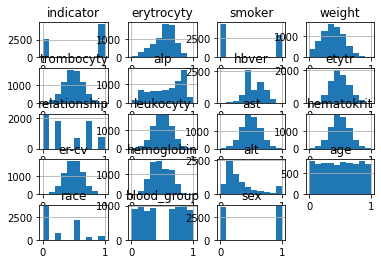

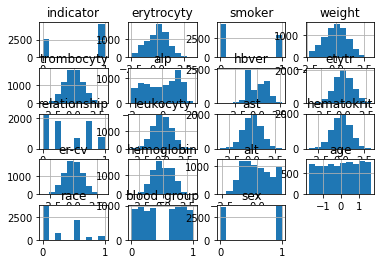

In [198]:
df_train.hist()
transformer = PowerTransformer(method="yeo-johnson")
columns = ["erytrocyty", "weight", "trombocyty", "alp", "hbver", "etytr", "leukocyty", "ast", "hematokrit", "er-cv", "hemoglobin", "alt", "age"]
df_train[columns] = transformer.fit_transform(df_train[columns])
df_train.hist()